In [1]:
import math
import torch
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
import gpytorch

import pandas as pd
import numpy as np

from gpytorch import lazy


%matplotlib inline
%load_ext autoreload
%autoreload 2

###  Loading and pre-processing the data

In [2]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

In [3]:
# choosing one input dimension and one output dimension as random
input_dim = np.random.permutation(list(train_data.iloc[:,:15].columns))
output_dim = np.random.permutation(list(train_data.iloc[:,15:-1].columns))

In [4]:
print(f"Input dimension to use: {input_dim[0]} and {input_dim[1]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: x and lognustar
Input dimension to use: vtiitg_gb_div_efiitg_gb


In [5]:
drop_data = train_data[[f'{input_dim[0]}',f'{input_dim[1]}',f'{output_dim[0]}']].dropna()

In [6]:
# drop_data = train_data[['smag','alpha','pfitem_gb_div_efetem_gb']].dropna()

In [7]:
x_train_data = drop_data.iloc[:,:2]
y_train_data = drop_data.iloc[:,2:]

assert x_train_data.shape[0] == y_train_data.shape[0]

In [8]:
n = 100
idx = np.random.permutation(n)

In [9]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_train_data = x_train_data.unsqueeze(0)
y_train_data = y_train_data.unsqueeze(0)

x_min0, x_max0 = x_train_data.min(), x_train_data.max()

In [10]:
gp = SingleTaskGP(x_train_data, y_train_data)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

In [11]:
# Get into evaluation (predictive posterior) mode
gp.eval()
gp.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    t1 = np.linspace(x_min0, x_max0 , 100)
    t2 =  np.linspace(x_min0, x_max0 , 100)
    
    test_x = torch.tensor(np.array(np.meshgrid(t1, t2)).T.reshape(-1,2), dtype = torch.double)
    
    observed_pred = gp.likelihood(gp(test_x))
    
    mean = observed_pred.mean
    variance = observed_pred.variance

In [12]:
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

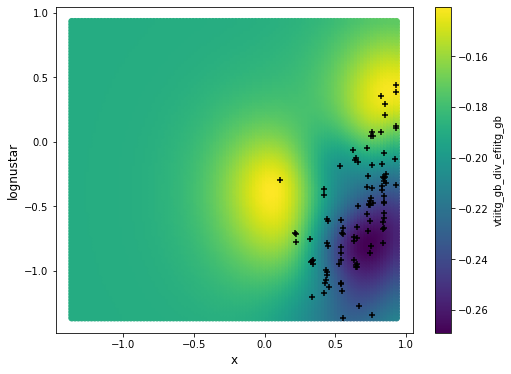

In [13]:
plt.figure(figsize = (8,6))
plt.scatter(test_x[:,0], test_x[:,1], c = output)
plt.colorbar(label =output_dim[0])
plt.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(),marker='+', color ='black')
plt.xlabel(input_dim[0], fontsize = 12);
plt.ylabel(input_dim[1], fontsize = 12);

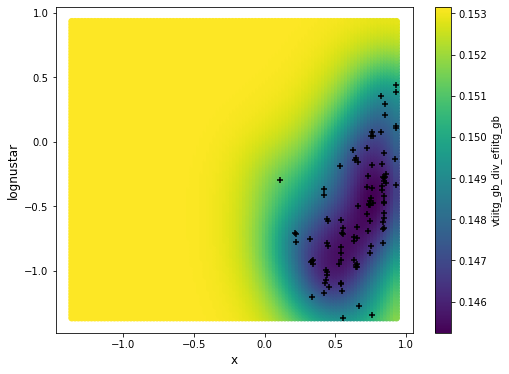

In [14]:
plt.figure(figsize = (8,6))
plt.scatter(test_x[:,0], test_x[:,1], c = out_var)
plt.colorbar(label =output_dim[0])
plt.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(),marker='+', color ='black')
plt.xlabel(input_dim[0], fontsize = 12);
plt.ylabel(input_dim[1], fontsize = 12);

## 3D Plots

In [15]:
from mpl_toolkits.mplot3d import Axes3D

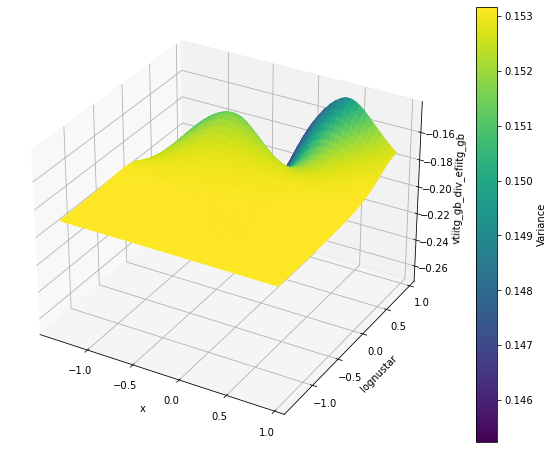

In [16]:
fig = plt.figure(figsize =(12,8))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(x_min0, x_max0 , 100)
y = np.linspace(x_min0, x_max0 , 100)
X, Y = np.meshgrid(x, y)
zs = output
Z = zs.reshape(X.shape)


scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(out_var.reshape(X.shape))

ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
# ax.scatter(x_train_data[:,:,0].squeeze(), x_train_data[:,:,1].squeeze(), y_train_data.squeeze(), marker='+', color ='black')

ax.set_xlabel(input_dim[0])
ax.set_ylabel(input_dim[1])
ax.set_zlabel(output_dim[0])

fig.colorbar(scamap, label = 'Variance')

plt.show()

## Three Input Dimensions One Output Dimension

In [17]:
drop_data = train_data[[f'{input_dim[0]}',f'{input_dim[1]}',f'{input_dim[2]}',f'{output_dim[0]}']].dropna()

In [18]:
print(f"Input dimension to use: {input_dim[0]}, {input_dim[1]} and {input_dim[1]}")
print(f"Input dimension to use: {output_dim[0]}")

Input dimension to use: x, lognustar and lognustar
Input dimension to use: vtiitg_gb_div_efiitg_gb


In [19]:
x_train_data = drop_data.iloc[:,:3]
y_train_data = drop_data.iloc[:,3:]

assert x_train_data.shape[0] == y_train_data.shape[0]

In [20]:
n = 100
idx = np.random.permutation(n)


In [21]:
x_train_data = torch.tensor(x_train_data.values)[idx]
y_train_data = torch.tensor(y_train_data.values)[idx]

x_train_data = x_train_data.unsqueeze(0)
y_train_data = y_train_data.unsqueeze(0)

x_min0, x_max0 = x_train_data.min(), x_train_data.max()

In [22]:
gp = SingleTaskGP(x_train_data, y_train_data)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

In [23]:
# Get into evaluation (predictive posterior) mode
gp.eval()
gp.likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    t0 = np.linspace(x_min0, x_max0 , 50)
    t1 = np.linspace(x_min0, x_max0 , 50)
    t2 = np.linspace(x_min0, x_max0 , 50)
    
    test_x = torch.tensor(np.array(np.meshgrid(t0, t1, t2)).T.reshape(-1,3), dtype = torch.double)
    
    observed_pred = gp.likelihood(gp(test_x))
    
    mean = observed_pred.mean
    variance = observed_pred.variance

In [24]:
output = mean.detach().numpy()
out_var = variance.detach().numpy().squeeze()
output = output.squeeze()

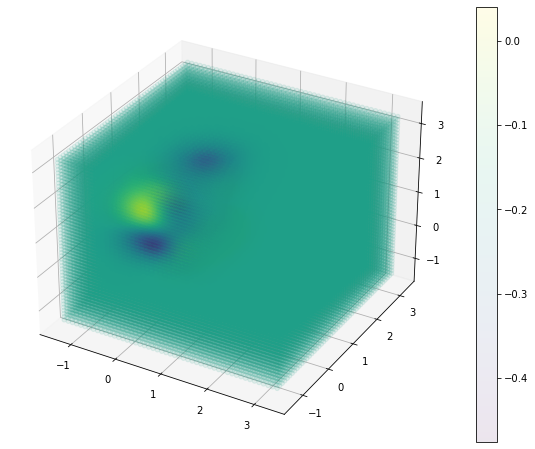

In [29]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
xs =test_x[:,0]
ys = test_x[:,1]
zs = test_x[:,2]
cs = output
# ax.scatter(xs, ys, zs, c=cs)
p = ax.scatter(xs, ys, zs, c=cs, alpha = 0.1)
fig.colorbar(p)

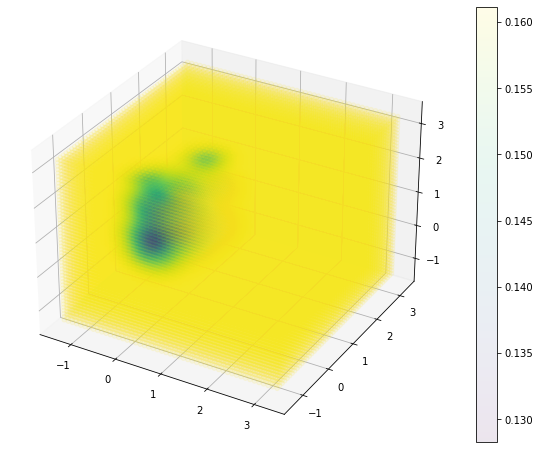

In [36]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')
xs =test_x[:,0]
ys = test_x[:,1]
zs = test_x[:,2]
cs = out_var
p = ax.scatter(xs, ys, zs, c=cs, alpha = 0.1)
fig.colorbar(p)